In [1]:
# packages to import, read in the latest dataframe pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import matplotlib
from colour import Color
from glob import glob
import re
import PIL
from PIL import Image

matplotlib.rcParams['pdf.fonttype'] = 42

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

pd.options.mode.chained_assignment = None 

In [2]:
#this makes a custom colormap for visualizing the footprints
#you input a list of colors (html codes), and a corresponding list of sizes
#this will generate a colormap which will have the given color at the corresponding size, and then will interpolate colors to the next size

def make_cp(colors, sizes):
    cp =[tuple([0,0,0,0])]*sizes[0] #0-20
    for i in range(len(colors)-1):
        cs=Color(colors[i])
        ce=Color(colors[i+1])
        for j in list(cs.range_to(ce, sizes[i+1]-sizes[i])):
            j=list(j.rgb)
            j.append(1)
            j=tuple(j)
            cp.append(j)

    return matplotlib.colors.ListedColormap(cp)

#the colormap I use in general

#colors Pol II and PIC sized footprints
colors=['#ed306f','#e42cf6','#f3aafa','#265de6','#33a040'] 
sizes=[20,            45,        55,   70,         100]
pol_cp=make_cp(colors, sizes)

In [3]:
#this makes a dataframe used to plot enrichment of specific footprint sizes w.r.t. position
#s is the start coordinate, e is the end coordinate
#min_s, max_s are the min and max size
#bin_size is if you want to do bins of sizes (so like every 5nt or whatever)

def plot_meta_heatmap(reads_df,s,e, min_s,max_s,bin_size):
    m_d=pd.DataFrame()
    reads_df=reads_df.fillna(0)[np.arange(s,e).astype(str)]
    reads_df[reads_df<=2]=0
    d=[]
    for s in range(min_s//bin_size,max_s//bin_size):
        df=reads_df.copy()
        df=df.where(df >= (s)*bin_size,0)
        df=df.where(df < (s+1)*bin_size,0)
        a=pd.DataFrame(df.sum(axis=0)).T
        d.append((s*bin_size))
        m_d=pd.concat([m_d,a], axis=0)
    m_d.index=d
    return m_d

In [4]:
#this generates an array with the enrichment of a given size range of footprints in a given range, normalized by read count at the position

def meta_line_plot(reads_df, start, end, fp_size_min, fp_size_max):
    
    df=reads_df.copy()
    
    count_df=df.copy()
    count_df[count_df!=2]=1
    count_df[count_df==2]=0
    counts=count_df.sum(axis=0)
    counts=counts.loc[np.arange(start,end).astype(str)]
    
    df[df <=2 ] = 0

    df=df.T
    df=df.loc[np.arange(start,end).astype(str)]
    df=df.T

    if fp_size_min:
        df=df.where(df > fp_size_min, 0)
    if fp_size_max:
        df=df.where(df < fp_size_max, 0)
    df=df.where(df == 0, 1)    
    
    df_a=df.sum(axis=0)
    df_a=np.array(df_a)/counts.to_numpy()
    df=''
    
    return df_a

In [5]:
# Define a function to read in the data
def read_data(file_paths, s, e):
    df_dict = {}
    for path in file_paths:
        # read in the path as a dataframe
        df = pd.read_csv(path, sep='\t', names=np.arange(s,e).astype(str))
        # extract df_name
        df_name = f'{path.split("/")[7]}_{path.split("/")[9].split("_")[0]}'
        # store the dataframe in the dictionary with the df_name as the key
        df_dict[df_name] = df
    return df_dict

In [6]:
#import the data
#you can import the entire dataset by leaving out the columns argument or you can choose a position range (s and e)
#parquet files require strings as their column names so you have to turn the arange into strings
#I would import at minimum 100 or so bases beyond the range you want to work with, just so that the smoothing for some of these plots doesn't have issues
# pEF-GFP
# s=0
# e=5054

# Define the base path to directory
base_path = '/gscratch/stergachislab/bmallo/large_home/hmm-footprint-caller/multi_cell_line/'

# Define the pattern to match the files
pattern_A375 = f'{base_path}A375*/Outfiles/A375*/*.tsv'
pattern_HAP1 = f'{base_path}HAP1*/Outfiles/HAP1*/*.tsv'
pattern_Hek293 = f'{base_path}Hek293*/Outfiles/Hek293*/*.tsv'
pattern_HepG2 = f'{base_path}HepG2*/Outfiles/HepG2*/*.tsv'
pattern_K562 = f'{base_path}K562*/Outfiles/K562*/*.tsv'

# Use glob to get a list of file paths
A375_paths = glob(pattern_A375)
HAP1_paths = glob(pattern_HAP1)
Hek293_paths = glob(pattern_Hek293)
HepG2_paths = glob(pattern_HepG2)
K562_paths = glob(pattern_K562)

# Create a dictionary to store dataframes in
A375 = read_data(A375_paths, 0, 5054)
HAP1 = read_data(HAP1_paths, 0, 5054)
Hek293 = read_data(Hek293_paths, 0, 5054)
HepG2 = read_data(HepG2_paths, 0, 5054)
K562 = read_data(K562_paths, 0, 5054)



In [7]:
def filter_dataframes(df_dict, threshold):
    df_dict_filtered = {}
    for df_name, df in df_dict.items():
        # Filter the dataframe to remove all reads whose first footprint is greater than threshold
        filtered_df = df[(abs(df.iloc[:, 1]) <= threshold) & (abs(df.iloc[:, 0]) <= threshold)]

        # Store the filtered dataframe back in the dictionary
        df_dict_filtered[df_name] = filtered_df
    return df_dict

# Filter dataframes
A375_filtered = filter_dataframes(A375, 1000)
HAP1_filtered = filter_dataframes(HAP1, 1000)
Hek293_filtered = filter_dataframes(Hek293, 1000)
HepG2_filtered = filter_dataframes(HepG2, 1000)
K562_filtered = filter_dataframes(K562, 1000)

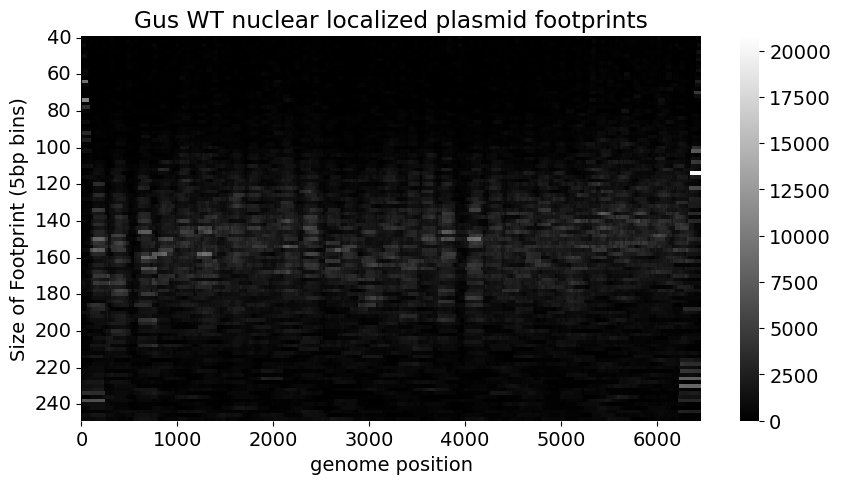

In [24]:
#plot the footprint size heatmap
bin_size=2
min_size=40
max_size=250
start=s
end=e

meta=plot_meta_heatmap(Gus_WT_Rep2_filterd, start, end, min_size, max_size, bin_size)

fig, ax=plt.subplots(1,1,figsize=(10,5))
sns.heatmap(data=meta, cbar=True, cmap='gray', ax=ax, xticklabels=1000, yticklabels=10)
ax.set_xlabel('genome position')
ax.set_ylabel('Size of Footprint (5bp bins)')
plt.title('Gus WT nuclear localized plasmid footprints')
plt.show()

In [ ]:
SLC39A4_Mut_filtered['Gus_MUT_rep2_29']

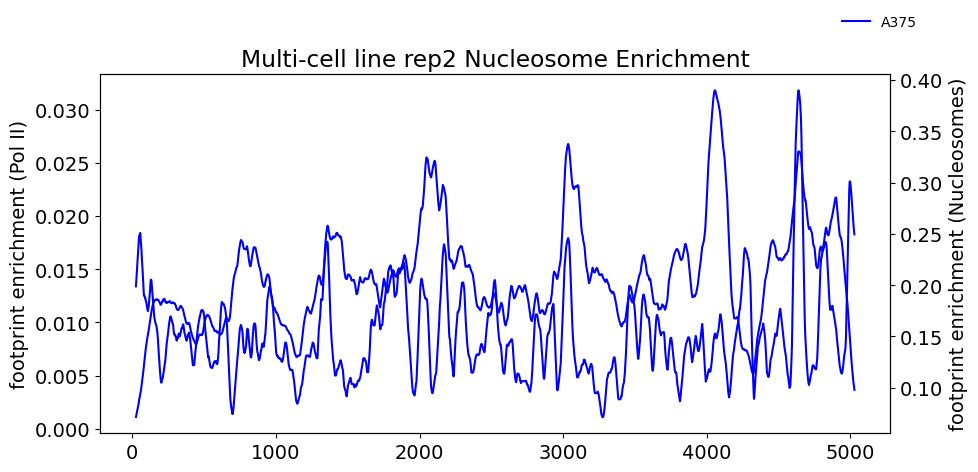

In [26]:
#plot the enrichment of PIC, pause, nucleosome sized footprints
s=25
e=5029
smooth=25
i=0

# Define samples to plot   
replicate = 'rep2'
nuc_range = (120, 10000)
PIC_range = (60, 80)

sample_1 = A375_filtered[f'A375_{replicate}_A375.all.m6a.gz']
sample_2 = HAP1_filtered[f'HAP1_{replicate}_HAP1.all.m6a.gz']
sample_3 = Hek293_filtered[f'Hek293_{replicate}_Hek293.all.m6a.gz']
sample_4 = HepG2_filtered[f'HepG2_{replicate}_HepG2.all.m6a.gz']
sample_5 = K562_filtered[f'K562_{replicate}_K562.all.m6a.gz']

fig, ax = plt.subplots(1,1,figsize=(10,5))

#grab the enrichment for nucleosomes
a=meta_line_plot(sample_1,  s-smooth, e+smooth, nuc_range[0], nuc_range[1])
b=meta_line_plot(sample_2,  s-smooth, e+smooth, nuc_range[0], nuc_range[1])
c=meta_line_plot(sample_3,  s-smooth, e+smooth, nuc_range[0], nuc_range[1])
d=meta_line_plot(sample_4,  s-smooth, e+smooth, nuc_range[0], nuc_range[1])
f=meta_line_plot(sample_5,  s-smooth, e+smooth, nuc_range[0], nuc_range[1])

#grab the enrichment for PIC
a2=meta_line_plot(sample_1,  s-smooth, e+smooth, PIC_range[0], PIC_range[1])
b2=meta_line_plot(sample_2,  s-smooth, e+smooth, PIC_range[0], PIC_range[1])
c2=meta_line_plot(sample_3,  s-smooth, e+smooth, PIC_range[0], PIC_range[1])
d2=meta_line_plot(sample_4,  s-smooth, e+smooth, PIC_range[0], PIC_range[1])
f2=meta_line_plot(sample_5,  s-smooth, e+smooth, PIC_range[0], PIC_range[1])

#do smoothing for nucleosomes
box = np.ones(smooth)/smooth
a = np.convolve(a, box, mode='same')
a = a[smooth:len(a)-smooth]
b = np.convolve(b, box, mode='same')
b = b[smooth:len(b)-smooth]
c = np.convolve(c, box, mode='same')
c = c[smooth:len(c)-smooth]
d = np.convolve(d, box, mode='same')
d = d[smooth:len(d)-smooth]
f = np.convolve(f, box, mode='same')
f = f[smooth:len(f)-smooth]

#do smoothing for PIC
a2 = np.convolve(a2, box, mode='same')
a2 = a2[smooth:len(a2)-smooth]
b2 = np.convolve(b2, box, mode='same')
b2 = b2[smooth:len(b2)-smooth]
c2 = np.convolve(c2, box, mode='same')
c2 = c2[smooth:len(c2)-smooth]
d2 = np.convolve(d2, box, mode='same')
d2 = d2[smooth:len(d2)-smooth]
f2 = np.convolve(f2, box, mode='same')
f2 = f2[smooth:len(f2)-smooth]

# plot PIC/Pol II
ax.plot(np.arange(s,e),a2, color='blue',label='A375')
# ax.plot(np.arange(s,e),b2, color='red',label='HAP1')
# ax.plot(np.arange(s,e),c2, color='green',label='Hek293')
# ax.plot(np.arange(s,e),d2, color='orange',label='HepG2')
# ax.plot(np.arange(s,e),f2, color='purple',label='K562')
# ax.set_ylim(0, 0.1)
# ax.set_xlim(s,e)

# Add vertical line at SNP position
# vline = ax.axvline(x=6119, color='purple', linestyle='--', linewidth=1, label='A>G')

#plot nucleosomes on a twin axis bc there are way more
ax2 = ax.twinx() 
ax2.plot(np.arange(s,e),a, color='blue',label='A375')
# ax2.plot(np.arange(s,e),b, color='red',label='HAP1')
# ax2.plot(np.arange(s,e),c, color='green',label='Hek293')
# ax2.plot(np.arange(s,e),d, color='orange',label='HepG2')
# ax2.plot(np.arange(s,e),f, color='purple',label='K562')

# Set labels and title 
plt.xlabel('genomic position')
ax.set_ylabel('footprint enrichment (Pol II)')
ax2.set_ylabel('footprint enrichment (Nucleosomes)')
plt.legend(loc='upper right', frameon=False, bbox_to_anchor=(1.05, 1.2), fontsize=10)
plt.title(f'Multi-cell line {replicate} Nucleosome Enrichment')
plt.tight_layout()

# Save figure
#output_path = f'/gscratch/stergachislab/bmallo/large_home/hmm-footprint-caller/figures/SLC39A4_WT_vs_MUT_{replicate_1}_vs_{replicate_2}_{count_1}_nucs.png'

# Add metadata
# Set standardized metadata information
# metadata = {
#     'Nucleosome Sizes': str(nuc_range),
#     'PIC sizes': str(PIC_range),  # You can include custom keys as well
# }

# # Save figure
# plt.savefig(output_path, metadata=metadata, bbox_inches='tight', dpi=300)


In [9]:
def plot_enrichment(s, e, smooth, allele_1, allele_2, count_1, count_2, replicate_1, replicate_2, nuc_range=(90,10000), PIC_range=(60, 80)):

    sample_1 = SLC39A4_WT_filtered[f'Gus_{allele_1}_{replicate_1}_{count_1}']
    sample_2 = SLC39A4_Mut_filtered[f'Gus_{allele_2}_{replicate_2}_{count_2}']

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    a = meta_line_plot(sample_1, s - smooth, e + smooth, nuc_range[0], nuc_range[1])
    b = meta_line_plot(sample_2, s - smooth, e + smooth, nuc_range[0], nuc_range[1])
    c = meta_line_plot(sample_1, s - smooth, e + smooth, PIC_range[0], PIC_range[1])
    d = meta_line_plot(sample_2, s - smooth, e + smooth, PIC_range[0], PIC_range[1])

    box = np.ones(smooth) / smooth
    a = np.convolve(a, box, mode='same')[smooth:len(a) - smooth]
    b = np.convolve(b, box, mode='same')[smooth:len(b) - smooth]
    c = np.convolve(c, box, mode='same')[smooth:len(c) - smooth]
    d = np.convolve(d, box, mode='same')[smooth:len(d) - smooth]

    ax.plot(np.arange(s, e), c, color='blue', label=f'{count_1}')
    ax.plot(np.arange(s, e), d, color='red', label=f'{count_2}')
    ax.set_ylim(0, 0.1)
    ax.set_xlim(s, e)

    vline = ax.axvline(x=6119, color='purple', linestyle='--', linewidth=1, label='A>G')

    ax2 = ax.twinx()
    ax2.plot(np.arange(s, e), a, color='blue', label=f'{allele_1}: {count_1} nucs')
    ax2.plot(np.arange(s, e), b, color='red', label=f'{allele_2}: {count_2} nucs')

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines2.append(lines[2])
    labels2.append(labels[2])

    ax.legend(lines2, labels2, loc='upper right', frameon=False, bbox_to_anchor=(1.05, 1.2), fontsize=10)

    plt.xlabel('genomic position')
    ax.set_ylabel('footprint enrichment (Pol II)')
    ax2.set_ylabel('footprint enrichment (Nucleosomes)')
    plt.title(f'SLC39A4: WT ({replicate_1}) vs MUT ({replicate_2})')
    plt.tight_layout()

    output_path = f'/gscratch/stergachislab/bmallo/large_home/hmm-footprint-caller/figures/SLC39A4_WT_vs_MUT_2/SLC39A4_WT_vs_MUT_{replicate_1}_vs_{replicate_2}_{count_1}_nucs.png'

    metadata = {
        'Nucleosome Sizes': str(nuc_range),
        'PIC sizes': str(PIC_range),
    }

    plt.savefig(output_path, metadata=metadata, bbox_inches='tight', dpi=300)
    plt.close(fig)

In [10]:
for count in range(1, 45):
    for replicate in ['rep1', 'rep2', 'rep3']:
        count_1 = count_2 = count
        replicate_1 = replicate_2 = replicate

        try:
            plot_enrichment(s=25, e=6437, smooth=25, allele_1='WT', allele_2='MUT',
                            count_1=count_1, count_2=count_2, replicate_1=replicate_1, replicate_2=replicate_2)
        except KeyError:
            # Handle the case where the sample does not exist
            print(f"Sample not found for count={count} and replicate={replicate}. Skipping...")


Sample not found for count=40 and replicate=rep1. Skipping...
Sample not found for count=41 and replicate=rep1. Skipping...
Sample not found for count=42 and replicate=rep1. Skipping...
Sample not found for count=42 and replicate=rep2. Skipping...
Sample not found for count=43 and replicate=rep1. Skipping...
Sample not found for count=43 and replicate=rep2. Skipping...
Sample not found for count=43 and replicate=rep3. Skipping...
Sample not found for count=44 and replicate=rep1. Skipping...
Sample not found for count=44 and replicate=rep2. Skipping...
Sample not found for count=44 and replicate=rep3. Skipping...


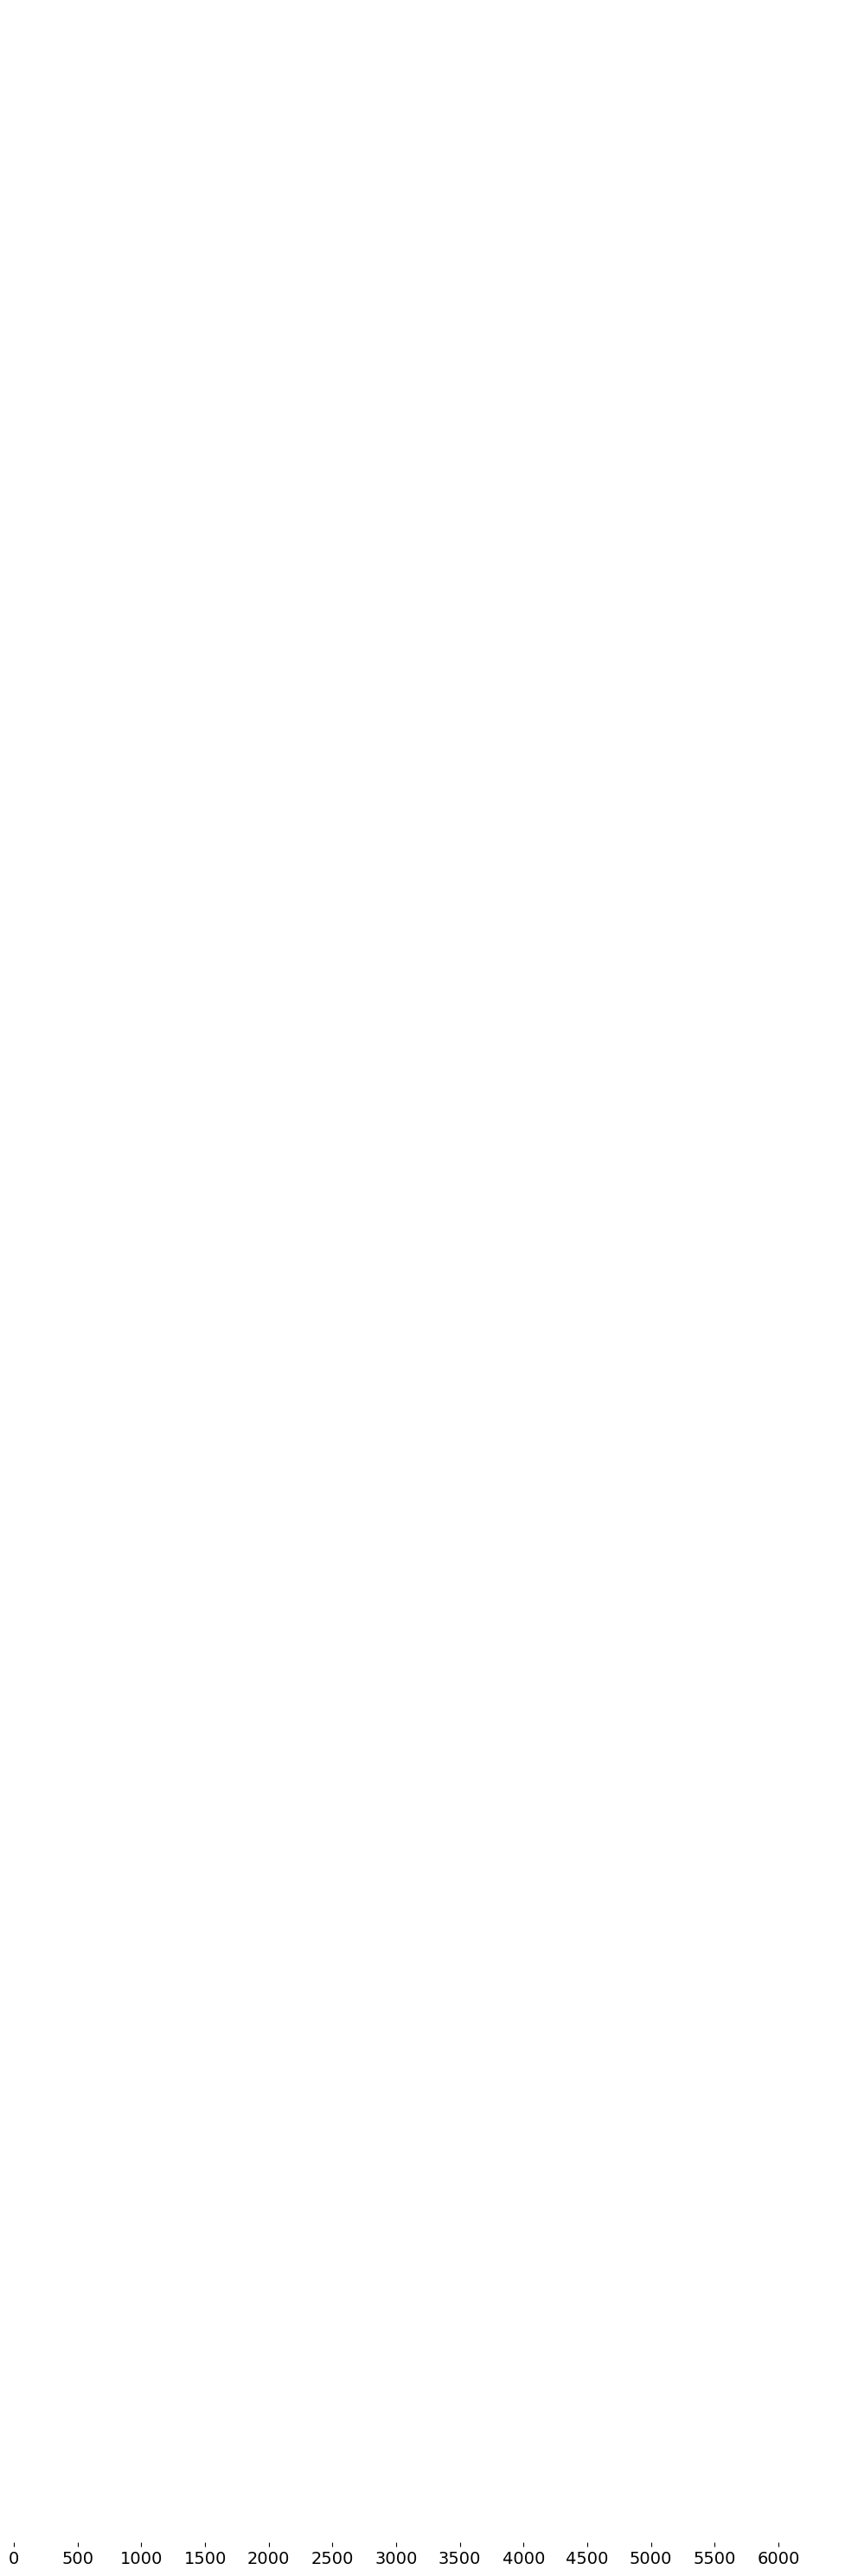

In [10]:
#plot all reads in a given region, colored by footprint identity

s=25
e=6400

fig, ax=plt.subplots(1,1, figsize=(10,30))

d=SLC39A4_WT_filtered['Gus_WT_rep3_22']
#you can do stuff like k-means clustering the dataframe or sorting by the distance to the 1st nucleosome or something to get different orders of reads if you want

# Specify the number of rows and the column index to center on
num_rows_to_plot = 400
center_column_index = 6000  # Replace with the desired column index

#these plot the white space and black lines
for i in range(d.shape[0]+1):
    ax.axhline(i+.5, color='black', lw=.25, zorder=1)
for i in range(d.shape[0]+1):
    ax.axhline(i, color='white', lw=2, zorder=3)

#this plots the actual reads
sns.heatmap(data=d,
cmap=pol_cp, vmin=0, vmax=1000,
            yticklabels=False, cbar=False, ax=ax,
            xticklabels=500)
plt.tight_layout()
plt.show()